# **IndustryLab - Progetto**

In [ ]:
#Installazione pacchetti
!pip install pyod
!pip install pykafka

In [ ]:
#Caricamento pacchetto
import statistics
import sys
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pylab import rcParams
from matplotlib.collections import PathCollection
from scipy.stats import iqr, zscore, shapiro, chi2
from sklearn.covariance import EllipticEnvelope
from scipy.spatial.distance import mahalanobis
from sklearn.neighbors import LocalOutlierFactor
from pyod.utils.utility import precision_n_scores
from pykafka import KafkaClient
from collections import Counter
from IPython.display import HTML
from sklearn.preprocessing import MinMaxScaler
import io
import base64
import datetime
sns.set(style="darkgrid")

In [ ]:
#Configurazione del layout
#https://stackoverflow.com/questions/21754976/ipython-notebook-arrange-plots-horizontally 

class FlowLayout(object):
    def __init__(self):
        self.sHtml =  """
        <style>
        .floating-box {
        display: inline-block;
        margin: 10px;
        border: 3px solid #888888;  
        }
        </style>
        """
    def add_plot(self, oAxes):
        Bio=io.BytesIO() 
        fig = oAxes.get_figure()
        fig.canvas.print_png(Bio) 
        sB64Img = base64.b64encode(Bio.getvalue()).decode()
        self.sHtml+= (
            '<div class="floating-box">'+ 
            '<img src="data:image/png;base64,{}\n">'.format(sB64Img)+
            '</div>')
    def PassHtmlToCell(self):
        ''' Final step - display the accumulated HTML '''
        display(HTML(self.sHtml))

oPlot = FlowLayout()

In [ ]:
#Caricamento db originale
db = pd.read_csv("/content/Caso2.csv")
db.head(1)

,Banco,CodiceDaLinea,Programma,Data_ora,Data,Ora,Turno,Master,coppia_max_ciclo,picco_coppia_zero,media_coppia_zero,picco_coppia_iniziale,media_coppia_iniziale,velocita_a_regime,picco_pressione_velocita_a_regime,media_pressione_velocita_a_regime,picco_portata_velocita_a_regime,media_portata_velocita_a_regime,velicita_1,picco_pressione_velocita_1,media_pressione_velocita_1,picco_portata_velocita_1,media_portata_velocita_1,velocita_2,picco_pressione_velocita_2,media_pressione_velocita_2,picco_portata_velocita_2,media_portata_velocita_2,picco_coppia_finale,media_coppia_finale,Temperatura,n_esito,esito
0,BancoGP5,010160954163140A00000000000,18_GP5_910_CW.DBF,2016-11-09 15:43:30,09/11/2016,15:43:30,B,,0.0,0.0,0.000917,0.0,0.0,2300.0,12.209582,12.041801,1343.039795,1341.342041,140.0,1.674603,1.643796,51.519997,51.481518,500.0,0.0,0.0,0.0,0.0,0.204679,0.1438,42.196945,100,PEZZO BUONO ...


## **Data Preparation**

In [ ]:
print(len(db.columns))
print(db.columns)

33
Index(['Banco', 'CodiceDaLinea', 'Programma', 'Data_ora', 'Data', 'Ora',
       'Turno', 'Master', 'coppia_max_ciclo', 'picco_coppia_zero',
       'media_coppia_zero', 'picco_coppia_iniziale', 'media_coppia_iniziale',
       'velocita_a_regime', 'picco_pressione_velocita_a_regime',
       'media_pressione_velocita_a_regime', 'picco_portata_velocita_a_regime',
       'media_portata_velocita_a_regime', 'velicita_1',
       'picco_pressione_velocita_1', 'media_pressione_velocita_1',
       'picco_portata_velocita_1', 'media_portata_velocita_1', 'velocita_2',
       'picco_pressione_velocita_2', 'media_pressione_velocita_2',
       'picco_portata_velocita_2', 'media_portata_velocita_2',
       'picco_coppia_finale', 'media_coppia_finale', 'Temperatura', 'n_esito',
       'esito'],
      dtype='object')


In [ ]:
classes = {}
for i in db.columns:
  classes[i]=len(db[i].unique())

#Useless variables
useless = dict((k, v) for k, v in classes.items() if v == 1)
useless_list = [i for i in useless.keys()]
useless_list

['Banco',
 'Master',
 'picco_coppia_zero',
 'picco_coppia_iniziale',
 'media_coppia_iniziale',
 'velicita_1',
 'picco_pressione_velocita_2',
 'media_pressione_velocita_2',
 'picco_portata_velocita_2',
 'media_portata_velocita_2']

#### Rimozione costanti

In [ ]:
useful = set([i for i in db.columns]) - set(useless_list) - set(['Data','Ora'])
db_ = db[[i for i in useful]]

In [ ]:
#Variabili finali
print("Num. variabili utili: ",len(db_.columns))
db_.columns

Num. variabili utili:  21


Index(['picco_pressione_velocita_1', 'Turno', 'picco_coppia_finale',
       'picco_portata_velocita_1', 'n_esito', 'Temperatura',
       'media_pressione_velocita_1', 'media_coppia_finale', 'Data_ora',
       'media_coppia_zero', 'media_portata_velocita_a_regime', 'velocita_2',
       'picco_pressione_velocita_a_regime', 'media_portata_velocita_1',
       'coppia_max_ciclo', 'velocita_a_regime',
       'picco_portata_velocita_a_regime', 'Programma', 'CodiceDaLinea',
       'esito', 'media_pressione_velocita_a_regime'],
      dtype='object')

In [ ]:
#Order by year
db_['Data_ora'] = pd.to_datetime(db_['Data_ora'])
db_ord = db.sort_values(by='Data_ora')

#### Rimozione `velocita_2`

In [ ]:
#Binario

#Useless variables
binary = dict((k, v) for k, v in classes.items() if v == 2)
binary = [i for i in binary.keys()]
binary

['velocita_2']

In [ ]:
db_.velocita_2.unique()

array([500., 100.])

In [ ]:
print(dict(Counter(db_.velocita_2)))

{500.0: 296598, 100.0: 7}


In [ ]:
#Rimozione velocita_2
db_.drop(['velocita_2'], axis='columns', inplace=True)

La variabile 'velocita_2' ha praticamente solo valori pari a 500.

In [ ]:
#Caricamento db ridotto
db = pd.read_csv("/content/DbRidotto.csv")
db.drop(['Unnamed: 0'], axis='columns', inplace=True)
db.head(1)

,picco_pressione_velocita_1,Turno,picco_coppia_finale,picco_portata_velocita_1,Temperatura,media_pressione_velocita_1,media_coppia_finale,Data_ora,media_portata_velocita_a_regime,picco_pressione_velocita_a_regime,media_portata_velocita_1,picco_portata_velocita_a_regime,Programma,esito,media_pressione_velocita_a_regime,Coefficiente
0,1.674603,B,0.204679,51.519997,42.196945,1.643796,0.1438,2016-11-09 15:43:30,1341.342041,12.209582,51.481518,1343.039795,18_GP5_910_CW.DBF,PEZZO BUONO ...,12.041801,34.601901


## **Analisi preliminari**

### **Variabili categoriche**

In [ ]:
#Numero di classi
print("Turno: ",len(db_.Turno.unique()))
print("Programma",len(db_.Programma.unique()))
print("CodiceDaLinea",len(db_.CodiceDaLinea.unique()))
print("Esito",len(db_.esito.unique()))

Turno:  9
Programma 18
CodiceDaLinea 294489
Esito 25


#### Rimozione `CodiceDaLinea`

In [ ]:
#Rimozione CodiceDaLinea
db_.drop(['CodiceDaLinea'], axis='columns', inplace=True)

#### Analisi `Turno`

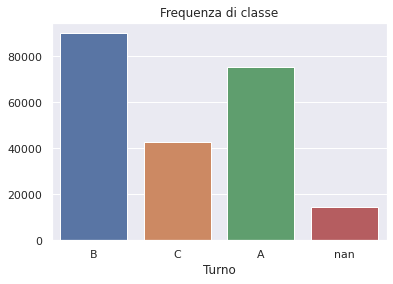

In [ ]:
##Analisi Turno

import warnings
warnings.filterwarnings("ignore")
db.Turno[db.Turno=="a"] = "A"
db.Turno[db.Turno=="b"] = "B"
db.Turno[db.Turno=="c"] = "C"
db.Turno[(db.Turno == "d")|(db.Turno == '0')] = "D"
db.Turno[(db.Turno == "nan")] = np.nan
db.Turno = db.Turno.apply(str)
#dbp.Turno = dbp.Turno.replace("nan", np.nan)
plt.subplot(111)
ax1 = sns.countplot(x="Turno", data=db)
plt.title("Frequenza di classe")
plt.ylabel("")
plt.show()

In [ ]:
#Mostra il nome e la frequenza di ogni turno
P = pd.DataFrame.from_dict(dict(Counter(db.Turno)),orient='index').reset_index()
P.columns = ['K','V']
P.reset_index()
P_ = P.sort_values('V',ascending=False)
P_ = P_.reset_index()
P_.columns = ['Fattore','Nome','Frequenza']
#Aggiung freq relativa
P_['%'] = P_.Frequenza/len(db)
P_ = P_[['Nome','Frequenza','%']]
P_

,Nome,Frequenza,%
0,B,90065,0.404679
1,A,75290,0.338292
2,C,42599,0.191405
3,nan,14605,0.065623


#### Analisi `Programma`

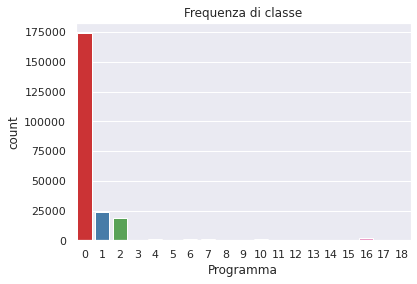

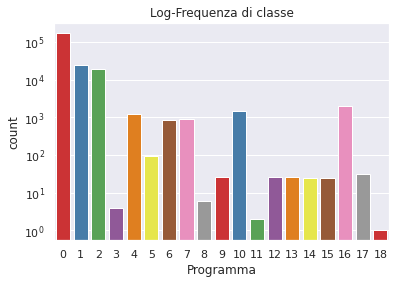

In [ ]:
#Analisi Programma

#Elaborazione per plot
dbp = db
dbp.Programma = dbp.Programma.apply(str)
dbp.Programma = pd.factorize(dbp.Programma)[0]

sns.set(style="darkgrid")
plt.subplot(111)
ax1 = sns.countplot(x="Programma", data=dbp, palette="Set1")
plt.title("Frequenza di classe")
plt.show()

plt.subplot(111)
ax = sns.countplot(x="Programma", data=dbp, palette="Set1")
ax.set_yscale('log')
plt.title("Log-Frequenza di classe")
plt.show()

In [ ]:
#Mostra il nome e la frequenza di ogni programma
P = pd.DataFrame.from_dict(dict(Counter(db.Programma)),orient='index').reset_index()
P.columns = ['K','V']
P.reset_index()
P_ = P.sort_values('V',ascending=False)
P_ = P_.reset_index()
P_.columns = ['Fattore','Nome','Frequenza']
#Aggiung freq relativa
P_['%'] = P_.Frequenza/len(db)
P_

,Fattore,Nome,Frequenza,%
0,0,18_GP5_910_CW.DBF,173972,0.779179
1,1,17_GP5_430_CCW.DBF,23641,0.105882
2,2,12_GP5_430B_D1.DBF,18932,0.084792
3,16,15_GP5_340_CCW.DBF,2029,0.009087
4,10,14_GP5_340_D1.DBF,1504,0.006736
5,4,13_GP5_500_CW.DBF,1234,0.005527
6,7,16_GP5_500_CCW.DBF,876,0.003923
7,6,05_GP5_340_S1.DBF,821,0.003677
8,5,058_GP5_CAMERARIDOTTA.DBF,95,0.000425
9,17,19_GP5S-CAMRID_CW.DBF,31,0.000139


#### Analisi `esito`

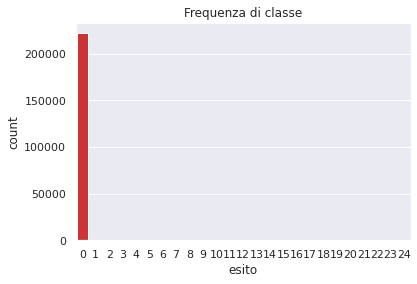

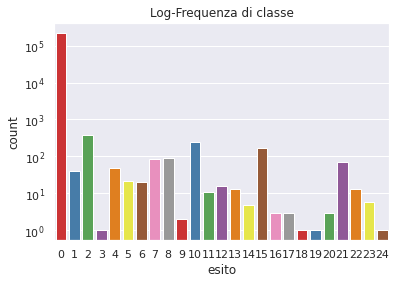

In [ ]:
#Analisi Esito

#Elaborazione per plot
dbp.esito = dbp.esito.apply(str)
l1 = pd.Series(pd.factorize(dbp.esito)[1])
l2 = pd.Series(db.esito.unique())
dbp.esito = pd.factorize(dbp.esito)[0]

plt.subplot(111)
ax1 = sns.countplot(x="esito", data=dbp, palette="Set1")
plt.title("Frequenza di classe")
plt.show()

plt.subplot(111)
ax = sns.countplot(x="esito", data=dbp, palette="Set1")
ax.set_yscale('log')
plt.title("Log-Frequenza di classe")
plt.show()

In [ ]:
#Mostra il nome e la frequenza di ogni esito
P = pd.DataFrame.from_dict(dict(Counter(db.esito)),orient='index').reset_index()
P.columns = ['K','V']
P.reset_index()
P_ = P.sort_values('V',ascending=False)
P_ = P_.reset_index()
P_.columns = ['Fattore','Nome','Frequenza']
#Aggiungi frequenza relativa
P_['%'] = P_.Frequenza/len(db)
P_

,Fattore,Nome,Frequenza,%
0,0,PEZZO BUONO ...,222031,0.994424
1,2,SCARTO PICCO COPPIA MAX FASE PULIZIA INIZIALE ...,373,0.001671
2,10,SCARTO PORTATA CONTROLLO VELOCITA'1 MIN MEDIA ...,241,0.001079
3,15,SCARTO COPPIA FINALE MAX MEDIA ...,171,0.000766
4,8,SCARTO PORTATA VELOCITA' A REGIME MAX PICCO ...,92,0.000412
5,7,SCARTO PRESSIONE CONTROLLO VELOCITA'1 MIN MEDI...,87,0.000390
6,21,SCARTO COPPIA MAX CICLO ...,71,0.000318
7,4,SCARTO PORTATA VELOCITA' A REGIME MIN MEDIA ...,48,0.000215
8,1,ANOMALIA AGGANCIO ...,40,0.000179
9,5,SCARTO PRESSIONE VELOCITA' A REGIME MAX PICCO ...,22,0.000099


#### Rimozione `n_esito`
`n_esito` è la versione numerica di `esito

In [ ]:
db.drop(['n_esito'], axis='columns', inplace=True)

### **Variabili numeriche**

In [ ]:
categ = ['Turno','Programma','esito','Data_ora']
db_num = db.drop([i for i in categ], axis='columns')

In [ ]:
db_num.head(1)

,picco_pressione_velocita_1,picco_coppia_finale,picco_portata_velocita_1,Temperatura,media_pressione_velocita_1,media_coppia_finale,media_portata_velocita_a_regime,picco_pressione_velocita_a_regime,media_portata_velocita_1,picco_portata_velocita_a_regime,media_pressione_velocita_a_regime,Coefficiente
0,1.674603,0.204679,51.519997,42.196945,1.643796,0.1438,1341.342041,12.209582,51.481518,1343.039795,12.041801,784.683851


#### **Descrittori della pressione**

In [ ]:
#Selezione delle variabili che riguardano la pressione
press = ['picco_pressione_velocita_1','media_pressione_velocita_1','picco_pressione_velocita_a_regime',
         'media_pressione_velocita_a_regime']

df_press = db[[k for k in press]]
df_press.columns = ['Picco Vel.1','Media Vel.1','Picco a regime','Media a regime']
df_press.head(1)

,Picco Vel.1,Media Vel.1,Picco a regime,Media a regime
0,1.674603,1.643796,12.209582,12.041801


In [ ]:
#Valori mancanti
for k in df_press.columns:
  print(k,":",len(df_press[df_press[k].isnull()]))

Picco Vel.1 : 1
Media Vel.1 : 1
Picco a regime : 1
Media a regime : 1


In [ ]:
missing = df_press[df_press.isnull().any(axis=1)]
missing.index.tolist()

[223275]

In [ ]:
#Rimozione dell'osservazione
db.drop(index=223275,inplace=True)
df_press.drop(index=223275,inplace=True)
db_num.drop(index=223275,inplace=True)
#db.to_csv("/content/DbRidotto.csv")


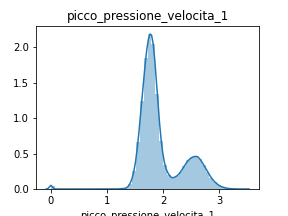
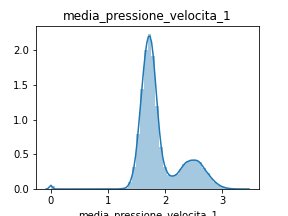
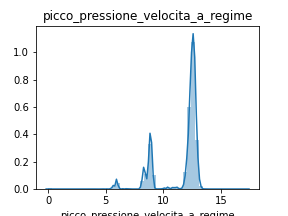
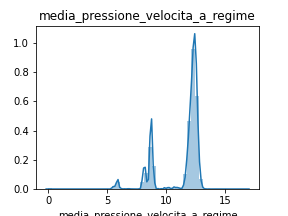

In [ ]:
#Distribuzione

for i in press: 
    fig, ax = plt.subplots(1, 1, figsize=(4,3))                      
    sns.distplot(db[i])
    plt.title(str(i)) 
    oPlot.add_plot(ax) 
    plt.close() 
oPlot.PassHtmlToCell()

In [ ]:
print("Media picco pressione (140rpm): ",db.picco_pressione_velocita_1.mean())
print("Media media pressione (140rpm): ",db.media_pressione_velocita_1.mean())
print("Media picco pressione (2300rpm): ",db.picco_pressione_velocita_a_regime.mean())
print("Media media pressione (2300rpm): ",db.media_pressione_velocita_a_regime.mean())
print("----------")
print("Massimo picco pressione (140rpm): ",db.picco_pressione_velocita_1.max())
print("Massimo media pressione (140rpm): ",db.media_pressione_velocita_1.max())
print("Massimo picco pressione (2300rpm): ",db.picco_pressione_velocita_a_regime.max())
print("Massimo media pressione (2300rpm): ",db.media_pressione_velocita_a_regime.max())
print("----------")
print("Minimo picco pressione (140rpm): ",db.picco_pressione_velocita_1.min())
print("Minimo media pressione (140rpm): ",db.media_pressione_velocita_1.min())
print("Minimo picco pressione (2300rpm): ",db.picco_pressione_velocita_a_regime.min())
print("Minimo media pressione (2300rpm): ",db.media_pressione_velocita_a_regime.min())

Media picco pressione (140rpm):  1.9385757190094528
Media media pressione (140rpm):  1.8830962788645433
Media picco pressione (2300rpm):  11.607109104991546
Media media pressione (2300rpm):  11.41235366869093
----------
Massimo picco pressione (140rpm):  3.4503331184387207
Massimo media pressione (140rpm):  3.3822250366210938
Massimo picco pressione (2300rpm):  14.208910942077635
Massimo media pressione (2300rpm):  14.013587951660154
----------
Minimo picco pressione (140rpm):  0.18853017687797546
Minimo media pressione (140rpm):  0.09659483283758163
Minimo picco pressione (2300rpm):  5.381837368011475
Minimo media pressione (2300rpm):  5.3268656730651855


In [ ]:
#Grouped dataframe
#https://stackoverflow.com/questions/57137902/split-violin-plot-for-two-variables-with-seaborn

vel1 = df_press[['Picco Vel.1','Media Vel.1']]
vel1['Tipo'] = "Vel. 1"
regime = df_press[['Picco a regime','Media a regime']]
regime['Tipo'] = "A regime"
grouped = pd.DataFrame()
grouped['Picco Pressione'] = pd.Series(vel1['Picco Vel.1'].append(regime['Picco a regime']))
grouped['Media Pressione'] = pd.Series(vel1['Media Vel.1'].append(regime['Media a regime']))
grouped['Tipo'] = pd.Series(vel1['Tipo'].append(regime['Tipo']))

#Grouped split dataframe
v = grouped[grouped.Tipo=="Vel. 1"]
r = grouped[grouped.Tipo=="A regime"]
v1 = pd.DataFrame({'Picco': v['Picco Pressione'],
                   'Media': v['Media Pressione']})
r1 = pd.DataFrame({'Picco': r['Picco Pressione'],
                   'Media': r['Media Pressione']})

#Pivoting
v1 = v1.melt().assign(x='Velocità 1')
r1 = r1.melt().assign(x="A regime")
v1.columns = ['Misura','Pressione','x'] 
r1.columns = ['Misura','Pressione','x']

#Final df
g = r1.append(v1)
g.columns = ['Misura','Pressione','x']

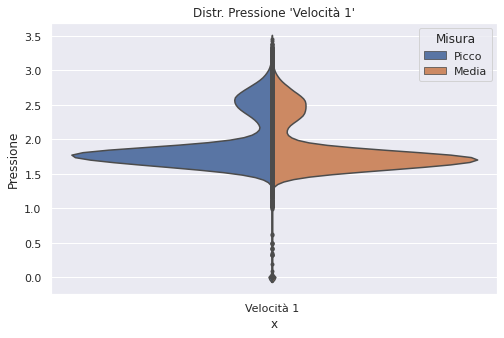

In [ ]:
#Violinplot Velocità 1
rcParams['figure.figsize'] = 8, 5


ax = sns.violinplot(data=v1, x='x', y='Pressione', 
               hue='Misura', split=True, inner="point")

plt.title("Distr. Pressione 'Velocità 1'")
plt.show()


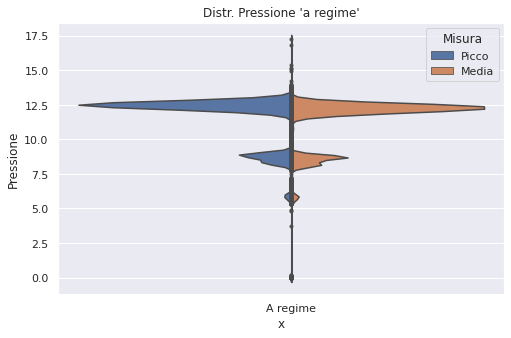

In [ ]:
#Violinplot A regime
rcParams['figure.figsize'] = 8, 5


ax = sns.violinplot(data=r1, x='x', y='Pressione', 
               hue='Misura', split=True, inner="point")

plt.title("Distr. Pressione 'a regime'")
plt.show()


Text(0.5, 1.0, 'Distribuzioni a confronto')

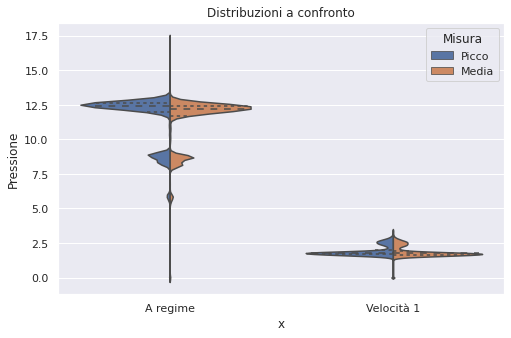

In [ ]:
#Violinplot

rcParams['figure.figsize'] = 8, 5

sns.violinplot(data=g, x='x', y='Pressione', 
               hue='Misura', split=True, inner='quart')
plt.title("Distribuzioni a confronto")

#### **Descrittori della portata**

In [ ]:
#Selezione delle variabili che riguardano la portata
port = ['media_portata_velocita_1','media_portata_velocita_a_regime','picco_portata_velocita_1',
        'picco_portata_velocita_a_regime']

df_port = db[[k for k in port]]
df_port.columns = ['Media Vel.1','Media a regime','Picco Vel.1','Picco a regime']
df_port.head(1)

,Media Vel.1,Media a regime,Picco Vel.1,Picco a regime
0,51.481518,1341.342041,51.519997,1343.039795


In [ ]:
#Valori mancanti
for k in df_port.columns:
  print(k,":",len(df_port[df_port[k].isnull()]))

Media Vel.1 : 0
Media a regime : 0
Picco Vel.1 : 0
Picco a regime : 0



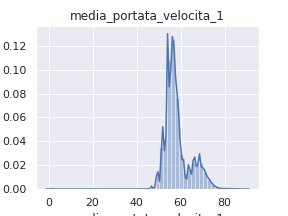
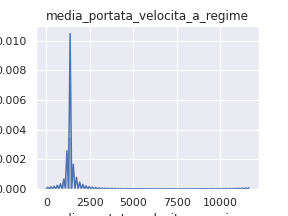
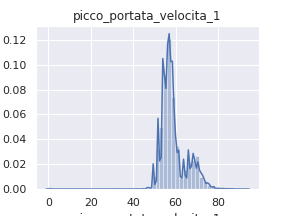
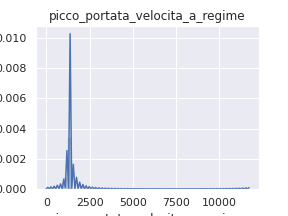

In [ ]:
#Distribuzione

for i in port: 
    fig, ax = plt.subplots(1, 1, figsize=(4,3))                      
    sns.distplot(db[i])
    plt.title(str(i)) 
    oPlot.add_plot(ax) 
    plt.close() 
oPlot.PassHtmlToCell()

In [ ]:
print("Media picco portata (140rpm): ",db.picco_portata_velocita_1.mean())
print("Media media portata (140rpm): ",db.media_portata_velocita_1.mean())
print("Media picco portata (2300rpm): ",db.picco_portata_velocita_a_regime.mean())
print("Media media portata (2300rpm): ",db.media_portata_velocita_a_regime.mean())
print("----------")
print("Massimo picco portata (140rpm): ",db.picco_portata_velocita_1.max())
print("Massimo media portata (140rpm): ",db.media_portata_velocita_1.max())
print("Massimo picco portata (2300rpm): ",db.picco_portata_velocita_a_regime.max())
print("Massimo media portata (2300rpm): ",db.media_portata_velocita_a_regime.max())
print("----------")
print("Minimo picco portata (140rpm): ",db.picco_portata_velocita_1.min())
print("Minimo media portata (140rpm): ",db.media_portata_velocita_1.min())
print("Minimo picco portata (2300rpm): ",db.picco_portata_velocita_a_regime.min())
print("Minimo media portata (2300rpm): ",db.media_portata_velocita_a_regime.min())

Media picco portata (140rpm):  58.9577970858148
Media media portata (140rpm):  58.488455222513515
Media picco portata (2300rpm):  1309.5586731086748
Media media portata (2300rpm):  1304.791656932243
----------
Massimo picco portata (140rpm):  93.5999984741211
Massimo media portata (140rpm):  90.00003051757812
Massimo picco portata (2300rpm):  1422.89990234375
Massimo media portata (2300rpm):  1416.2398681640625
----------
Minimo picco portata (140rpm):  30.304845809936523
Minimo media portata (140rpm):  28.07365226745605
Minimo picco portata (2300rpm):  930.4799194335938
Minimo media portata (2300rpm):  927.5978393554688


In [ ]:
#Grouped dataframe
vel1 = df_port[['Picco Vel.1','Media Vel.1']]
vel1['Tipo'] = "Vel. 1"
regime = df_port[['Picco a regime','Media a regime']]
regime['Tipo'] = "A regime"
grouped = pd.DataFrame()
grouped['Picco Portata'] = pd.Series(vel1['Picco Vel.1'].append(regime['Picco a regime']))
grouped['Media Portata'] = pd.Series(vel1['Media Vel.1'].append(regime['Media a regime']))
grouped['Tipo'] = pd.Series(vel1['Tipo'].append(regime['Tipo']))

#Grouped split dataframe
v = grouped[grouped.Tipo=="Vel. 1"]
r = grouped[grouped.Tipo=="A regime"]
v1 = pd.DataFrame({'Picco': v['Picco Portata'],
                   'Media': v['Media Portata']})
r1 = pd.DataFrame({'Picco': r['Picco Portata'],
                   'Media': r['Media Portata']})

#Pivoting
v1 = v1.melt().assign(x='Velocità 1')
r1 = r1.melt().assign(x="A regime")
v1.columns = ['Misura','Portata','x'] 
r1.columns = ['Misura','Portata','x']

#Final df
g = v1.append(r1)
g.columns = ['Misura','Portata','x']

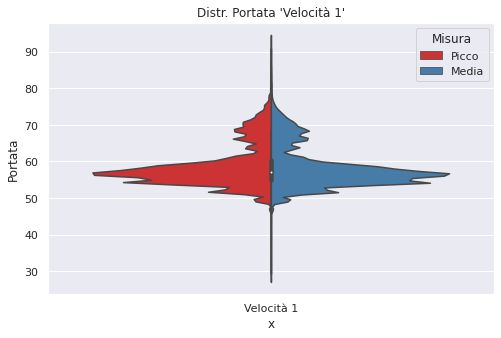

In [ ]:
#Violinplot Velocità 1
rcParams['figure.figsize'] = 8, 5


ax = sns.violinplot(data=v1, x='x', y='Portata', 
               hue='Misura', split=True, palette="Set1")

plt.title("Distr. Portata 'Velocità 1'")
plt.show()

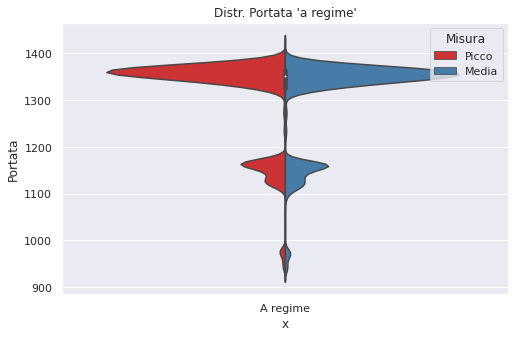

In [ ]:
#Violinplot A regime
rcParams['figure.figsize'] = 8, 5


ax = sns.violinplot(data=r1, x='x', y='Portata', 
               hue='Misura', split=True, palette="Set1")

plt.title("Distr. Portata 'a regime'")
plt.show()

Text(0, 0.5, 'LogPortata')

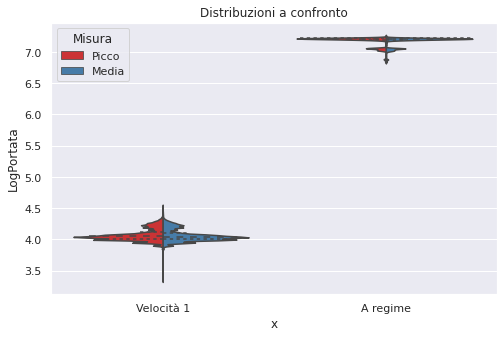

In [ ]:
#Violinplot

rcParams['figure.figsize'] = 8, 5

sns.violinplot(data=g, x='x', y=np.log(g['Portata']), 
               hue='Misura', split=True, inner='quart', palette="Set1")
plt.title("Distribuzioni a confronto")
plt.ylabel("LogPortata")

### **Altre variabili**

In [ ]:
altre = set(db_num.columns)-set(press)-set(port)
altre

{'Temperatura',
 'coppia_max_ciclo',
 'media_coppia_finale',
 'media_coppia_zero',
 'picco_coppia_finale',
 'velocita_a_regime'}

In [ ]:
#Valori mancanti
for k in altre:
  print(k,":",len(db_num[db_num[k].isnull()]))

media_coppia_zero : 0
media_coppia_finale : 0
coppia_max_ciclo : 0
velocita_a_regime : 0
picco_coppia_finale : 0
Temperatura : 0


### `coppia_max_ciclo`

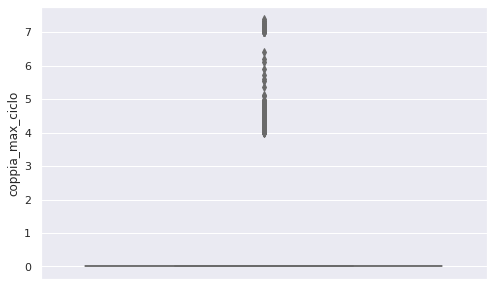

In [ ]:
sns.boxplot(data=db_num, y='coppia_max_ciclo',palette="Set3")

In [ ]:
#Quantità di 0
print("% valori nulli in coppia_max_ciclo:",len(db_num[db_num['coppia_max_ciclo']==0])/len(db_num))
print("Num valori non nulli:",len(db_num[db_num['coppia_max_ciclo']!=0]),"su",len(db_num))

% valori nulli in coppia_max_ciclo: 0.9979666421827693
Num valori non nulli: 454 su 223276


In [ ]:
#Rimozione 
db.drop(['coppia_max_ciclo'], axis='columns', inplace=True)
db_num.drop(['coppia_max_ciclo'], axis='columns', inplace=True)

### `media_coppia_finale`

Text(0, 0.5, 'Media coppia finale')

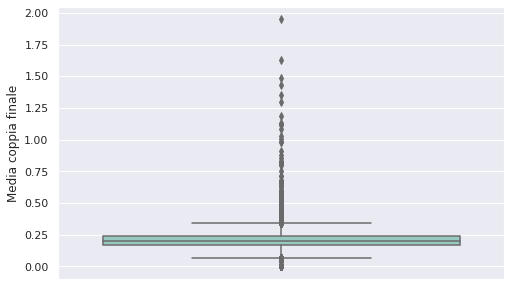

In [ ]:
sns.boxplot(data=db, y='media_coppia_finale',palette="Set3")
plt.ylabel("Media coppia finale")

### `media_coppia_zero`

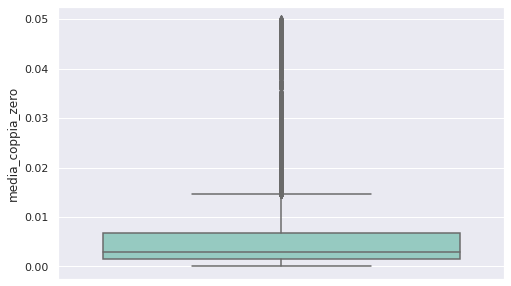

In [ ]:
sns.boxplot(data=db_num, y='media_coppia_zero',palette="Set3")

La variabile viene rimossa perché non ritenuta significativa ai fini dell'analisi di correlazione dai fornitori del database.

In [ ]:
db.drop(['media_coppia_zero'], axis='columns', inplace=True)

### `picco_coppia_finale`

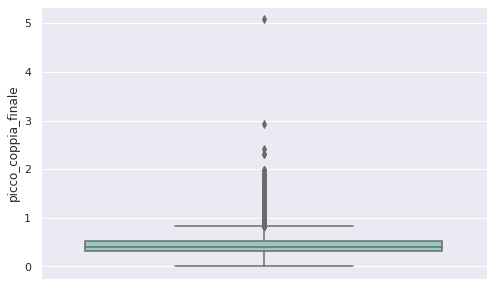

In [ ]:
sns.boxplot(data=db_num, y='picco_coppia_finale',palette="Set3")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


Text(0, 0.5, 'LogValori')

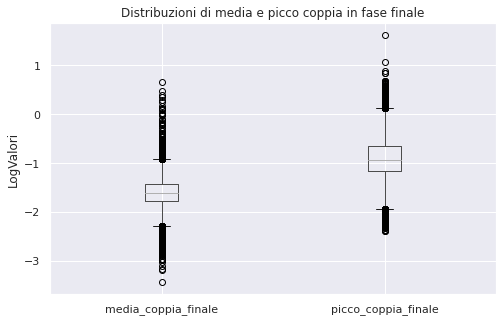

In [ ]:
np.log(db[['media_coppia_finale','picco_coppia_finale']]).boxplot()
plt.title("Distribuzioni di media e picco coppia in fase finale")
plt.ylabel("LogValori")

### `velocita_a_regime`


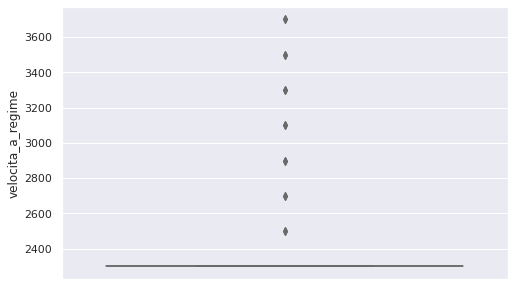

In [ ]:
sns.boxplot(data=db_num, y='velocita_a_regime',palette="Set3")

In [ ]:
#Valori unici
db_num.velocita_a_regime.unique()

array([2300., 2500., 2700., 2900., 3100., 3300., 3500., 3700.])

In [ ]:
#Valori di frequenza
V = pd.DataFrame.from_dict(dict(Counter(db_num.velocita_a_regime)),orient='index').reset_index()
V.columns = ['Valore','Frequenza']
V['%'] = V.Frequenza/len(db_num)
V

,Valore,Frequenza,%
0,2300.0,223261,0.999937
1,2500.0,2,0.000009
2,2700.0,2,0.000009
3,2900.0,2,0.000009
4,3100.0,2,0.000009
5,3300.0,2,0.000009
6,3500.0,2,0.000009
7,3700.0,2,0.000009


In [ ]:
#Rimozione 
db.drop(['velocita_a_regime'], axis='columns', inplace=True)
db_num.drop(['velocita_a_regime'], axis='columns', inplace=True)

### `Temperatura`

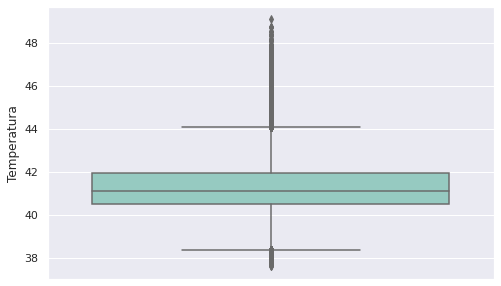

In [ ]:
sns.boxplot(data=db_num, y='Temperatura',palette="Set3")

In [ ]:
#Range temperatura:
print("Temperatura minima:",db.Temperatura.min())
print("Temperatura massima:",db.Temperatura.max())
print("Temperatura media:",db.Temperatura.mean())

Temperatura minima: 37.61205673217773
Temperatura massima: 49.10082626342773
Temperatura media: 41.232832188006675


### **Correlazione fra variabili numeriche**

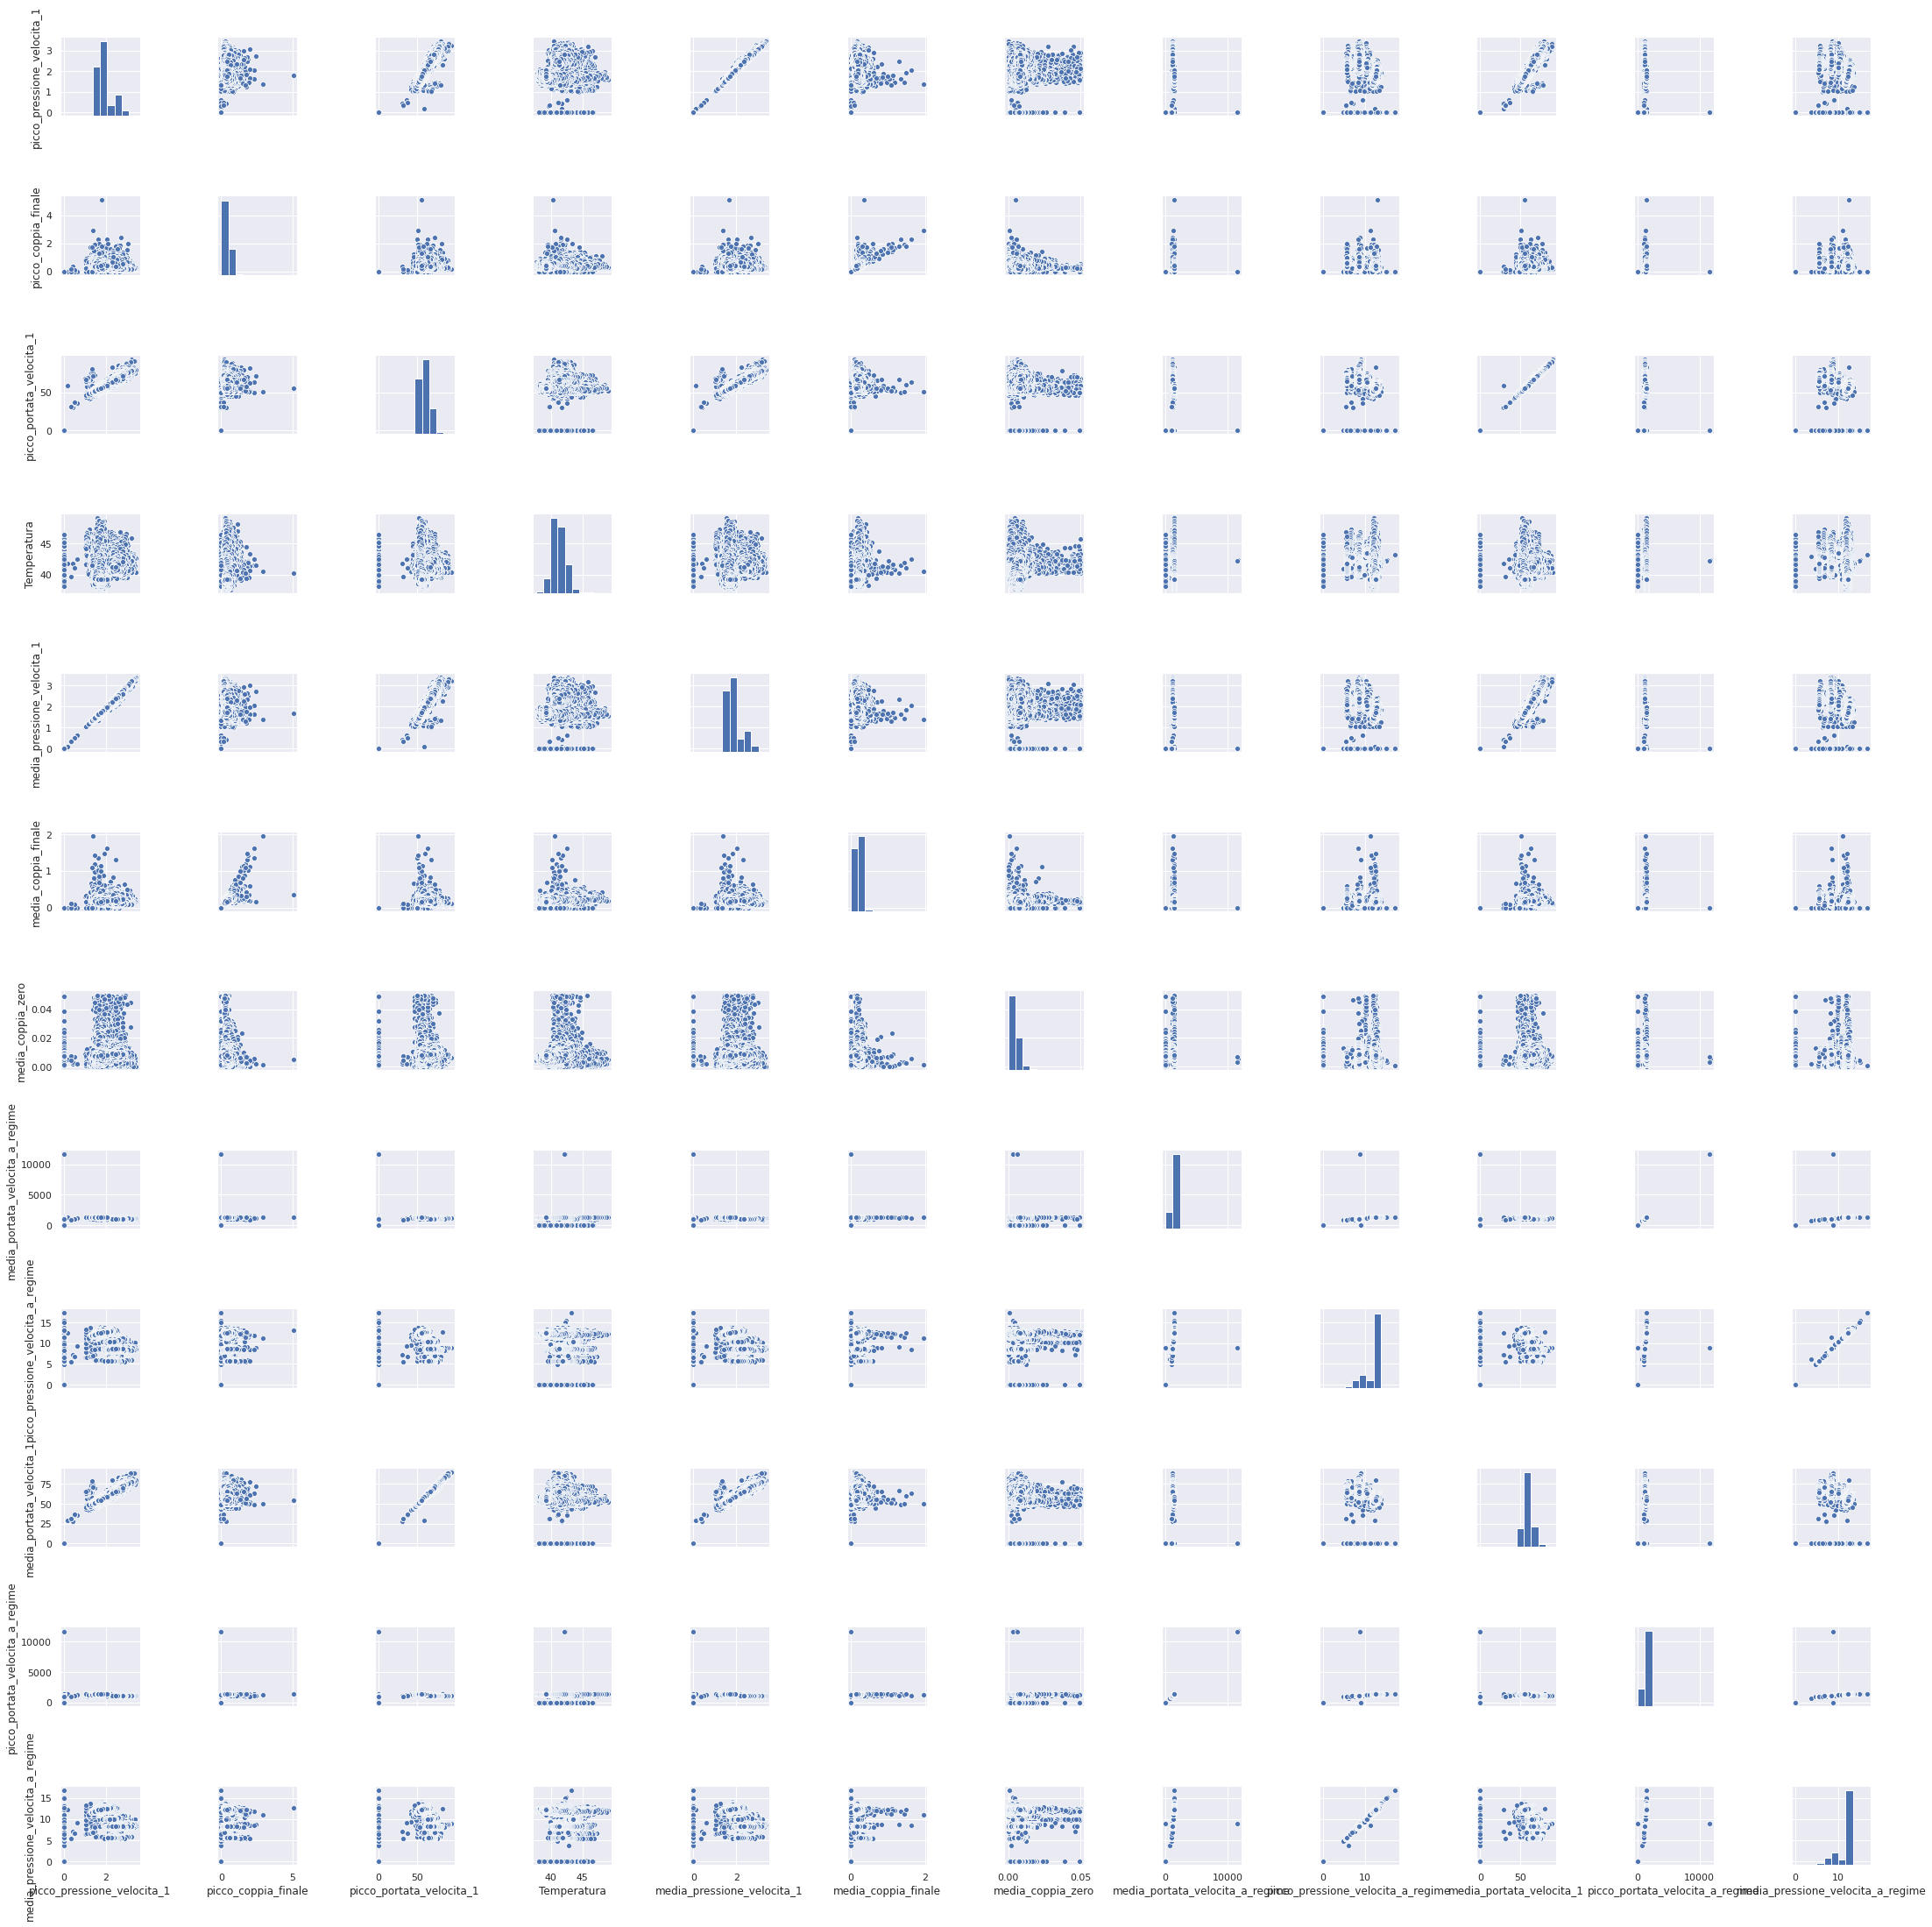

In [ ]:
#Correlogramma
sns.pairplot(db_num)

In [ ]:
#Correlation matrix
db_num.columns = ['Picco Pressione Vel.1', 'Picco coppia Fin.',
       'Picco Portata Vel.1', 'Temp.', 'Media Pressione Vel.1',
       'Media coppia Fin.', 'Media coppia 0',
       'Media Portata a reg.', 'Picco Pressione a reg.',
       'Media Portata Vel.1', 'Picco portata a reg.',
       'Media Pressione a reg.']
c = db_num.corr()
c.round(decimals=3)

,Picco Pressione Vel.1,Picco coppia Fin.,Picco Portata Vel.1,Temp.,Media Pressione Vel.1,Media coppia Fin.,Media coppia 0,Media Portata a reg.,Picco Pressione a reg.,Media Portata Vel.1,Picco portata a reg.,Media Pressione a reg.
Picco Pressione Vel.1,1.000,-0.040,0.903,0.076,0.997,-0.134,-0.015,-0.502,-0.674,0.909,-0.501,-0.671
Picco coppia Fin.,-0.040,1.000,0.027,0.191,-0.058,0.833,-0.081,0.060,0.045,0.028,0.063,0.036
Picco Portata Vel.1,0.903,0.027,1.000,0.044,0.899,-0.005,0.047,-0.344,-0.532,0.998,-0.339,-0.531
Temp.,0.076,0.191,0.044,1.000,0.072,0.126,-0.086,-0.104,-0.115,0.044,-0.104,-0.119
Media Pressione Vel.1,0.997,-0.058,0.899,0.072,1.000,-0.160,-0.030,-0.499,-0.672,0.905,-0.498,-0.666
Media coppia Fin.,-0.134,0.833,-0.005,0.126,-0.160,1.000,-0.006,0.164,0.165,-0.008,0.171,0.150
Media coppia 0,-0.015,-0.081,0.047,-0.086,-0.030,-0.006,1.000,-0.016,-0.007,0.045,-0.011,-0.017
Media Portata a reg.,-0.502,0.060,-0.344,-0.104,-0.499,0.164,-0.016,1.000,0.912,-0.340,1.000,0.913
Picco Pressione a reg.,-0.674,0.045,-0.532,-0.115,-0.672,0.165,-0.007,0.912,1.000,-0.529,0.911,0.999
Media Portata Vel.1,0.909,0.028,0.998,0.044,0.905,-0.008,0.045,-0.340,-0.529,1.000,-0.335,-0.529


In [ ]:
##Estrai maggiori collinearità:
#Si contano le collinearità superiori al 50% per ogni variabile

def coll(col):
  count = len(c[abs(c[col])>=0.5])-1
  m = (sum(abs(c[col]))-1)/(len(c[col])-1)
  return count, m

In [ ]:
collinearità = []
nome = []
media = []

for i in c.index:
  nome.append(i)
  count,m = coll(i)
  collinearità.append(count)
  media.append(m)

coll_df = pd.DataFrame({"Variabile":nome,
                        "Collinearità":collinearità,
                        "|Media|": media})

coll_df = coll_df.sort_values('|Media|',ascending=False)
coll_df

,Variabile,Collinearità,|Media|
8,Picco Pressione a reg.,7,0.505604
11,Media Pressione a reg.,7,0.503754
4,Media Pressione Vel.1,5,0.495897
0,Picco Pressione Vel.1,7,0.492804
7,Media Portata a reg.,4,0.441109
10,Picco portata a reg.,4,0.440503
2,Picco Portata Vel.1,5,0.424498
9,Media Portata Vel.1,5,0.424377
5,Media coppia Fin.,1,0.174647
1,Picco coppia Fin.,1,0.132856


Le variabili più collegate sono quelle legate rispettivamente alla `velocità1` e `velocità a regime`, per cui si calcolano le matrici di correlazione per le due grandezze. Inoltre, in qualche caso le variabili sono correlate ($\text{corr}>0.5$) anche se riferite a velocità diverse, ma alla stessa grandezza:
- pressione
- portata

In [ ]:
#Correlazione fra variabili di velocità 1
vel1 = ['picco_pressione_velocita_1', 'media_pressione_velocita_1','picco_portata_velocita_1',
       'media_portata_velocita_1']
df_vel1 =  db[[k for k in vel1]]
df_vel1.columns = ['Picco pressione Vel.1', 'Media pressione Vel.1','Picco portata Vel.1',
       'Media portata Vel.1']
c = df_vel1.corr()
c.round(decimals=3)

,Picco pressione Vel.1,Media pressione Vel.1,Picco portata Vel.1,Media portata Vel.1
Picco pressione Vel.1,1.000,0.997,0.903,0.909
Media pressione Vel.1,0.997,1.000,0.899,0.905
Picco portata Vel.1,0.903,0.899,1.000,0.998
Media portata Vel.1,0.909,0.905,0.998,1.000


In [ ]:
db.columns

Index(['picco_pressione_velocita_1', 'Turno', 'picco_coppia_finale',
       'picco_portata_velocita_1', 'Temperatura', 'media_pressione_velocita_1',
       'media_coppia_finale', 'Data_ora', 'media_coppia_zero',
       'media_portata_velocita_a_regime', 'picco_pressione_velocita_a_regime',
       'media_portata_velocita_1', 'picco_portata_velocita_a_regime',
       'Programma', 'esito', 'media_pressione_velocita_a_regime'],
      dtype='object')

In [ ]:
#Correlazione fra variabili di velocità a regime
reg = ['media_portata_velocita_a_regime', 'picco_portata_velocita_a_regime','media_pressione_velocita_a_regime',
       'picco_pressione_velocita_a_regime']
df_reg =  db[[k for k in reg]]
df_reg.columns = ['Media portata a reg.', 'Picco portata a reg.','Media pressione a reg.',
       'Picco pressione a reg.']
c = df_reg.corr()
c.round(decimals=3)

,Media portata a reg.,Picco portata a reg.,Media pressione a reg.,Picco pressione a reg.
Media portata a reg.,1.000,1.000,0.913,0.912
Picco portata a reg.,1.000,1.000,0.911,0.911
Media pressione a reg.,0.913,0.911,1.000,0.999
Picco pressione a reg.,0.912,0.911,0.999,1.000


In [ ]:
#Correlazione fra variabili di pressione
c = df_press.corr()
c.round(decimals=3)

,Picco Vel.1,Media Vel.1,Picco a regime,Media a regime
Picco Vel.1,1.000,0.997,-0.674,-0.671
Media Vel.1,0.997,1.000,-0.672,-0.666
Picco a regime,-0.674,-0.672,1.000,0.999
Media a regime,-0.671,-0.666,0.999,1.000


In [ ]:
#Correlazione fra variabili di pressione
c = df_port.corr()
c.round(decimals=3)

,Media Vel.1,Media a regime,Picco Vel.1,Picco a regime
Media Vel.1,1.000,-0.340,0.998,-0.335
Media a regime,-0.340,1.000,-0.344,1.000
Picco Vel.1,0.998,-0.344,1.000,-0.339
Picco a regime,-0.335,1.000,-0.339,1.000


In [ ]:
db.columns

Index(['picco_pressione_velocita_1', 'Turno', 'picco_coppia_finale',
       'picco_portata_velocita_1', 'Temperatura', 'media_pressione_velocita_1',
       'media_coppia_finale', 'Data_ora', 'media_portata_velocita_a_regime',
       'picco_pressione_velocita_a_regime', 'media_portata_velocita_1',
       'picco_portata_velocita_a_regime', 'Programma', 'esito',
       'media_pressione_velocita_a_regime', 'Coefficiente'],
      dtype='object')

Text(0.5, 1.0, 'Correlazione assoluta fra pressione e portata')

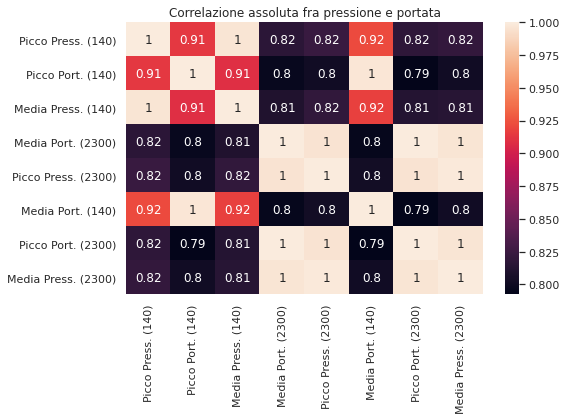

In [ ]:
#Correlazione fra variabili di portata e pressione
c = ['picco_pressione_velocita_1','picco_portata_velocita_1','media_pressione_velocita_1',
     'media_portata_velocita_a_regime','picco_pressione_velocita_a_regime',
     'media_portata_velocita_1','picco_portata_velocita_a_regime',
     'media_pressione_velocita_a_regime']
df_c =  db[[k for k in c]]
df_c.columns = ['Picco Press. (140)','Picco Port. (140)','Media Press. (140)',
     'Media Port. (2300)','Picco Press. (2300)','Media Port. (140)','Picco Port. (2300)',
     'Media Press. (2300)']
c = df_c.corr()
c.round(decimals=3)
sns.heatmap(np.abs(c), annot=True)
plt.title("Correlazione assoluta fra pressione e portata")

## **Coefficiente di leakage**

Partendo dalla formulazione generale
$$Q_{GP}=Q_{GP_\text{Teo}}-\alpha\bullet P_{\text{out}}$$
il coefficiente di dispersione è calcolato, in base alla fase implementata, come segue:
$$\alpha_{140}=\frac{108.36-\text{Media portata (@140)}}{\text{Media pressione (@140)}}$$

$$\alpha_{2300}=\frac{1780.2-\text{Media portata (@2300)}}{\text{Media pressione (@2300)}}$$

Le successive analisi sul coefficiente di dispersione andranno a considerare solamente la distribuzione di $\alpha$ in corrispondenza di 140 rpm , poiché le grandezze relative alle due fasi, benché separate, appaiono spesso generate dalla stessa distribuzione. Come conseguenza di ciò, effettuare un'analisi anche sulla distribuzione osservata in corrispondenza della fase a regime rivelerebbe comportamenti analoghi.

La variabile `Programma` raccoglie le classi di GP5 - tipi di pompe - che condividono lo stesso coefficiente di leakage.

In [ ]:
#È legato quindi alle classi della variabile 'Programma'
db.Programma.unique()

array(['18_GP5_910_CW.DBF', '17_GP5_430_CCW.DBF', '12_GP5_430B_D1.DBF',
       '08_GP5_910_D1.DBF', '13_GP5_500_CW.DBF',
       '058_GP5_CAMERARIDOTTA.DBF', '05_GP5_340_S1.DBF',
       '16_GP5_500_CCW.DBF', '01_GP5_430_S1.DBF',
       '01_MASTER1_D1_MASTER.DBF', '14_GP5_340_D1.DBF',
       '04_GP5_500_D1.DBF', '03_MASTER3_D1_MASTER.DBF',
       '04_MASTER1_S1_MASTER.DBF', '05_MASTER2_S1_MASTER.DBF',
       '06_MASTER3_S1_MASTER.DBF', '15_GP5_340_CCW.DBF',
       '19_GP5S-CAMRID_CW.DBF'], dtype=object)

In [9]:
#Creazione coeff di leakage (140 RPM)
db['Coefficiente_140'] = (108.36-db['media_portata_velocita_1'])/db['media_pressione_velocita_1']
db.Coefficiente_140

0         34.601901
1         26.129255
2         36.598894
3         31.023595
4         25.635736
            ...    
222554    31.937072
222555    33.813938
222556    30.774172
222557    29.258391
222558    31.612534
Name: Coefficiente_140, Length: 222559, dtype: float64

In [10]:
#Controlla presenza di valori non calcolati
db[db['Coefficiente_140'].isna()][['Coefficiente_140',"media_portata_velocita_a_regime",'media_portata_velocita_1','media_pressione_velocita_1']]

,Coefficiente_140,media_portata_velocita_a_regime,media_portata_velocita_1,media_pressione_velocita_1


Text(0.5, 1.0, 'Distribuzione coefficiente (140 rpm)')

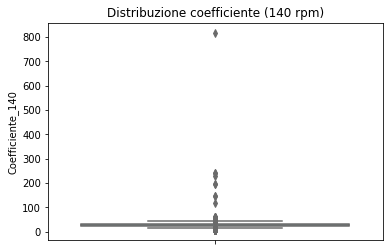

In [13]:
sns.boxplot(data=db, y='Coefficiente_140',palette="Set3")
plt.title("Distribuzione coefficiente (140 rpm)")

Text(0.5, 1.0, 'Distribuzione logaritmica')

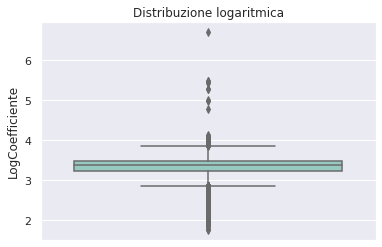

In [ ]:
#Distribuzione logaritmica
sns.boxplot(data=db, y=np.log(db['Coefficiente_140']),palette="Set3")
plt.ylabel("LogCoefficiente")
plt.title("Distribuzione logaritmica")

In [ ]:
print("Minimo coefficiente:",db.Coefficiente_140.min())
print("Massimo coefficiente:",db.Coefficiente_140.max())
print("Media coefficiente:",db.Coefficiente_140.mean())

Minimo coefficiente: 5.716359676995397
Massimo coefficiente: 817.1244306638182
Media coefficiente: 27.772763388877024


In [14]:
#Descrizione del coefficiente (IN FASE DI CONTROLLO)
pd.DataFrame(db.Coefficiente_140.describe())

,Coefficiente_140
count,222559.000000
mean,27.772763
std,7.192042
min,5.716360
25%,25.050613
50%,29.426504
75%,32.344987
max,817.124431


Si mostra la distribuzione raggruppata per `programma`:

Text(0.5, 1.0, 'Distribuzione per programma')

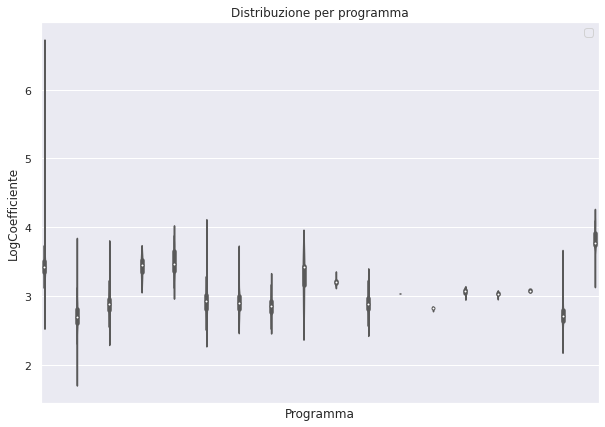

In [ ]:
rcParams['figure.figsize'] = 10, 7
sns.violinplot(x="Programma", y=np.log(db["Coefficiente_140"]), hue="Programma",palette="Set2",data=db)
plt.ylabel("LogCoefficiente")
plt.xticks([])
plt.legend('')
plt.title("Distribuzione per programma")

Si mostra ora la correlazione rispetto alle altre variabili numeriche:

In [16]:
var = set(db.columns)-set(["media_portata_velocita_a_regime",'media_portata_velocita_1','media_pressione_velocita_1'])-set(['Data_ora','Programma','Turno','esito'])
d =  db[[k for k in var]]
c = d.corr()
print("Correlazioni rispetto a 'Coefficiente_140':")
d1 = pd.DataFrame(c.Coefficiente_140)
d1 = d1.iloc[(-np.abs(d1['Coefficiente_140'].values)).argsort()]
d1.iloc[1:]

Correlazioni rispetto a 'Coefficiente_140':


,Coefficiente_140
picco_pressione_velocita_1,-0.941528
picco_portata_velocita_1,-0.916270
picco_pressione_velocita_a_regime,0.750328
media_pressione_velocita_a_regime,0.746763
picco_portata_velocita_a_regime,0.743338
media_coppia_finale,0.168668
picco_coppia_finale,0.069531
Temperatura,-0.066246


La variabile `picco_portata_velocità_a_regime` è perfettamente positivamente correlata con la variabile `media_portata_velocità_a_regime`.

Si mostra ora l'andamento della serie storica nel tempo:

In [ ]:
db["Data_ora"]=pd.to_datetime(db["Data_ora"])
pd.DataFrame(db["Data_ora"].describe())

,Data_ora
count,222559
unique,222559
top,2018-10-17 18:33:35
freq,1
first,2016-11-09 15:43:30
last,2019-10-04 19:49:47


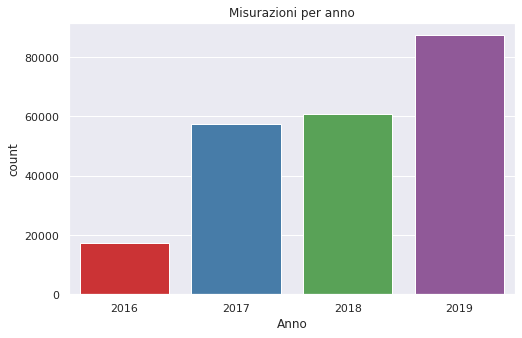

In [ ]:
def anno(x):
  date = datetime.datetime.strptime(str(x), "%Y-%m-%d  %H:%M:%S")
  return date.year

def mese(x):
  date = datetime.datetime.strptime(str(x), "%Y-%m-%d  %H:%M:%S")
  return date.month

def giorno(x):
  date = datetime.datetime.strptime(str(x), "%Y-%m-%d  %H:%M:%S")
  return date.day

#Estrai anno
db['Anno'] = db.Data_ora.apply(anno)
#Distribuzione anni
rcParams['figure.figsize'] = 8, 5
sns.countplot(x="Anno", data=db, palette="Set1")
plt.title("Misurazioni per anno")
plt.show()

Text(0.5, 1.0, 'Distribuzione per anno')

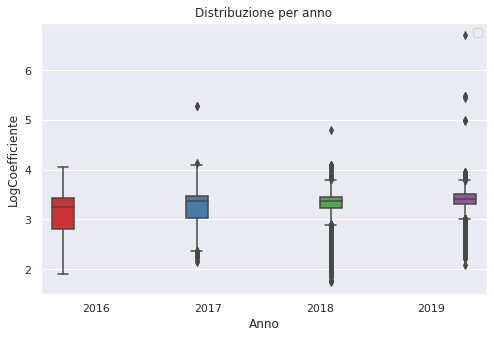

In [ ]:
#Distribuzione coefficiente per anno
sns.boxplot(x="Anno", y=np.log(db["Coefficiente_140"]), hue="Anno",palette="Set1",data=db)
plt.ylabel("LogCoefficiente")
plt.legend('')
plt.title("Distribuzione per anno")


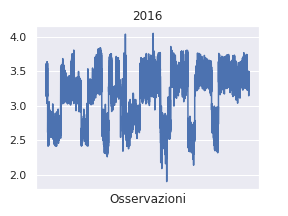
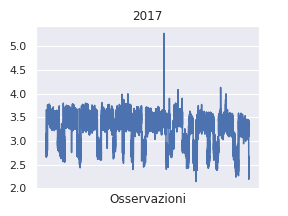
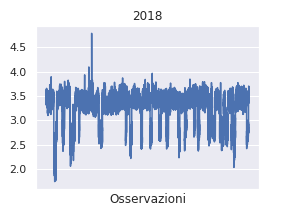
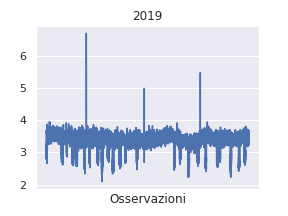

In [ ]:
#Serie storiche in base all'anno
for i in db.Anno.unique(): 
    fig, ax = plt.subplots(1, 1, figsize=(4,3))                      
    plt.plot(range(len(db[db.Anno == i])), np.log(db[db.Anno == i]["Coefficiente_140"]))
    plt.xlabel("Osservazioni")
    plt.xticks([])
    plt.title(str(i)) 
    oPlot.add_plot(ax) 
    plt.close() 
oPlot.PassHtmlToCell()

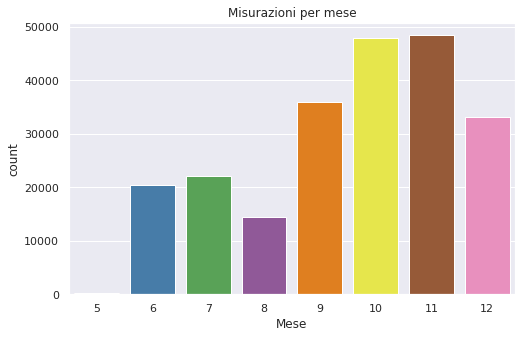

In [ ]:
#Estrai mese
db['Mese'] = db.Data_ora.apply(mese)
#Distribuzione mesi
rcParams['figure.figsize'] = 8, 5
sns.countplot(x="Mese", data=db, palette="Set1")
plt.title("Misurazioni per mese")
plt.show()

Le misurazioni non state prese con coerenza cronologica.

In [ ]:
#Si individua l'ordine con cui i gruppi vengono misurati (range di indici)
for k in db.Programma.unique():
  lista = db.Programma[db.Programma==k].index.tolist()
  print(k,":",lista[0],"-",lista[len(lista)-1])

18_GP5_910_CW.DBF : 0 - 222558
17_GP5_430_CCW.DBF : 126 - 218458
12_GP5_430B_D1.DBF : 3515 - 221054
08_GP5_910_D1.DBF : 3517 - 63787
058_GP5_CAMERARIDOTTA.DBF : 5912 - 68022
13_GP5_500_CW.DBF : 6453 - 174760
05_GP5_340_S1.DBF : 7329 - 34468
16_GP5_500_CCW.DBF : 10214 - 83290
01_GP5_430_S1.DBF : 14440 - 47966
01_MASTER1_D1_MASTER.DBF : 21507 - 57546
14_GP5_340_D1.DBF : 21524 - 210265
04_GP5_500_D1.DBF : 47967 - 47967
03_MASTER3_D1_MASTER.DBF : 57547 - 57572
04_MASTER1_S1_MASTER.DBF : 57573 - 57598
05_MASTER2_S1_MASTER.DBF : 57599 - 57623
06_MASTER3_S1_MASTER.DBF : 57624 - 57648
15_GP5_340_CCW.DBF : 62863 - 174472
19_GP5S-CAMRID_CW.DBF : 87408 - 218189



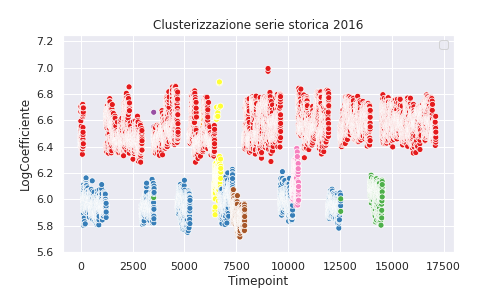
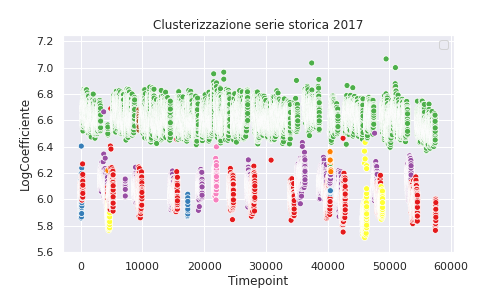
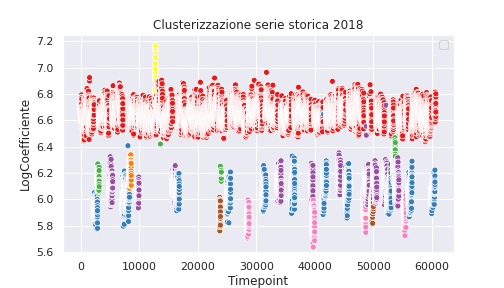
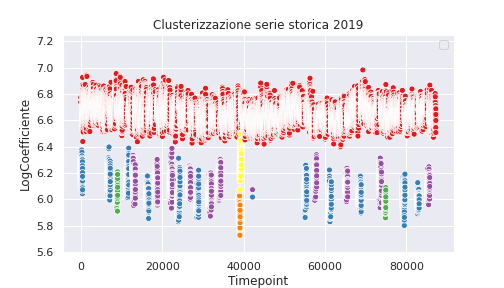

In [ ]:
#Clusterizzazione della serie storica in base all'anno
for i in db.Anno.unique(): 
    fig, ax = plt.subplots(1, 1, figsize=(7,4))                      
    sns.scatterplot(x=range(len(db[db.Anno == i])), y=np.log(db[db.Anno == i]["Coefficiente_140"]),hue=db[db.Anno==i]['Programma'],palette="Set1")
    plt.legend('')
    plt.ylabel('LogCoefficiente')
    plt.ylim(5.6, 7.25)
    plt.xlabel('Timepoint')
    plt.title("Clusterizzazione serie storica "+str(i))
    oPlot.add_plot(ax) 
    plt.close() 
oPlot.PassHtmlToCell()

Text(0.5, 0, 'Osservazioni')

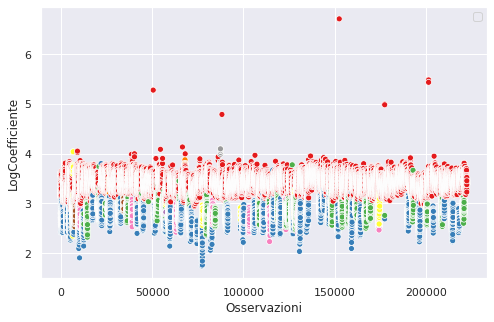

In [ ]:
#Si rappresenta l'intera serie storica
sns.scatterplot(x=range(len(db)), y=np.log(db["Coefficiente_140"]),hue=db['Programma'],palette="Set1")
plt.legend('')
plt.ylabel('LogCoefficiente')
plt.xlabel('Osservazioni')

È chiaro come la periodicità del valore del coefficiente non derivi da una correlazione temporale fra i valori stessi, bensì dall'ordine con cui si sceglie di effettuare le misurazioni sui diversi gruppi GP5, che, come si è visto in precedenza, hanno distribuzioni differenti.

NB: I colori delle classi sono riassegnati ad ogni plot. Nonostante i colori siano diversi, la classe più popolosa è con valore del coefficiente più elevato rimane sempre: `18_GP5_910_CW.DBF` (in rosso nel 2016, 2018, 2019 e in verde nel 2017).

## **Data scaling**

È necessario mappare le variabili fra 0 e 1.

In [17]:
scaler = MinMaxScaler()
vars_num = set(db_num.columns)
db_scaled = db
db_scaled[[i for i in vars_num]] = scaler.fit_transform(db_scaled[[k for k in vars_num]])
db_scaled.head(1)

,picco_pressione_velocita_1,Turno,picco_coppia_finale,picco_portata_velocita_1,Temperatura,media_pressione_velocita_1,media_coppia_finale,Data_ora,media_portata_velocita_a_regime,picco_pressione_velocita_a_regime,media_portata_velocita_1,picco_portata_velocita_a_regime,Programma,esito,media_pressione_velocita_a_regime,Coefficiente_140,Anno
0,0.455599,B,0.040291,0.335178,0.399076,0.470899,0.073801,2016-11-09 15:43:30,0.846723,0.7735,0.377995,0.837821,18_GP5_910_CW.DBF,PEZZO BUONO ...,0.773011,0.035599,2016


##**Outliers univariati**



In [ ]:
#Caricamente db scalato
db_scaled = pd.read_csv("/content/DbScalato.csv")
db_scaled.drop(['Unnamed: 0'], axis='columns', inplace=True)

Si analizzano i valori anomali della variabile target `Coefficiente`. Prima, però, è necessario verificare che la distribuzione scalata sia effettivamente normale, in modo da esser certi di poterli individuare sfruttando un cutoff sulla z-score, anziché usare il metodo non parametrico della distanza interquartile. Innanzitutto, si osserva la forma della distribuzione scalata e il rispettivo Quantile-Quantile Plot, con cui è possibile confrontare la variabile con una Normale teorica:

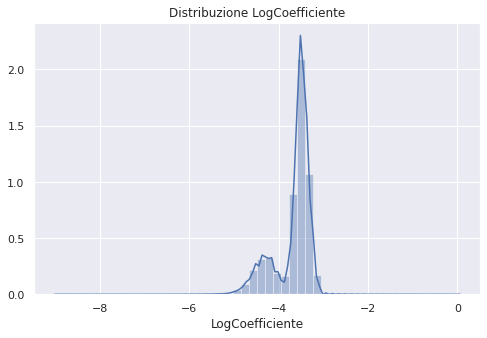

In [ ]:
sns.distplot(np.log(db_scaled.Coefficiente_140[db_scaled.Coefficiente_140>0]))
plt.xlabel("LogCoefficiente")
plt.title("Distribuzione LogCoefficiente")
plt.show()

In [ ]:
#Test di normalità Shapiro-Wilk
stat, p = shapiro(db_scaled.Coefficiente_140)
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
	print('Sample looks Gaussian (fail to reject H0)')
else:
	print('Sample does not look Gaussian (reject H0)')

Statistics=0.871, p=0.000
Sample does not look Gaussian (reject H0)


/usr/local/lib/python3.6/dist-packages/scipy/stats/morestats.py:1676: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


In [ ]:
def out_uni(y, type):
  Q1, Q3 = np.quantile(y,[0.25, 0.75])
  IQR = iqr(y)
  if type == "iqr":
    mask = (y < Q1 - 1.5 * IQR) | (y > Q3 + 1.5 * IQR)
  elif type == "zscore":
    mask = np.abs(zscore(y) > 3.5)
  idx = np.where(mask)
  return [i for i in idx[0]]

#Seleziona indici degli outliers
ind = out_uni(db_scaled.Coefficiente_140,type="iqr")

Si controlla se gli outliers si verificano in determinate condizioni: con un particolare programma, quando si presenta una determinata anomalia nella produzione del pezzo o durante determinati periodi.

In [ ]:
db_out = db_scaled.iloc[ind][['Coefficiente_140','Programma','esito','Turno','Data_ora']]

print("Programmi: ",len(db_out.Programma.unique()))
print("Esiti: ",len(db_out.esito.unique()))
print("Turni: ",db_out.Turno.unique())

Programmi:  10
Esiti:  7
Turni:  ['B' 'C' 'A' nan]


In [ ]:
#Data/mese
db_out['Anno'] = db_out.Data_ora.apply(anno)
db_out['Mese'] = db_out.Data_ora.apply(mese)
print("Anni: ",db_out.Anno.unique())
print("Mesi: ",db_out.Mese.unique())

Anni:  [2016 2017 2018 2019]
Mesi:  [11 12  9 10  6  7  8]


È possibile concludere che i valori anomali non dipendano da precise condizioni, né periodi.

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


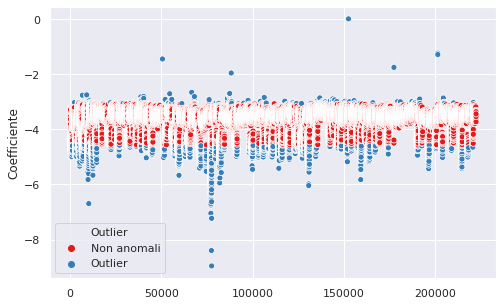

In [ ]:
db_scaled['Outlier']="Non anomali"
db_scaled['Outlier'].loc[ind]="Outlier"
sns.scatterplot(x=range(len(db_scaled)),y=np.log(db_scaled.Coefficiente_140),hue=db_scaled.Outlier,palette="Set1")
db_scaled.drop(['Outlier'], axis='columns', inplace=True)

##**Novelty Detection**

In [ ]:
def LOF(x):
  lier_indicator = []
  lof = LocalOutlierFactor()
  c = lof.fit_predict(x)
  score = - lof.negative_outlier_factor_
  for k in score:
    if k > 1:
      lier_indicator.append("Outlier")
    elif (k > 1.1) | (k < 0.9):
      lier_indicator.append("Border")
    else:
      lier_indicator.append("Inlier")
  return lier_indicator

LOFoutliers = LOF(db_num)
db_num['LOFoutliers'] = LOFoutliers
print("Outlier:",len(db_num[db_num.LOFoutliers=="Outlier"])/len(db_num))
print("Border:",len(db_num[db_num.LOFoutliers=="Border"])/len(db_num))

Outlier: 0.7494596938339946
Border: 0.0


In [ ]:
l = db_num[db_num.LOFoutliers=="Outlier"].index.tolist()
print(len(db.loc[[i for i in l]]['Programma'].unique()))
print(db.loc[[i for i in l]]['Turno'].unique())
print(len(db.loc[[i for i in l]]['esito'].unique()))

18
['B' 'C' 'A' nan]
12


Gli outlier multivariati individuati dal metodo `Local Outlier Factor` non si presentano in condizioni particolari di programma, turno o esito.